In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [92]:
NUM_EPOCHS = 100
BATCH_SIZE = 256
BUFFER_SIZE = 1024
STEPS_PER_EPOCH = 100
LEARNING_RATE = 0.0001

ACTIVATION_ELU = tf.keras.activations.elu
ACTIVATION_SOFTPLUS = tf.keras.activations.softplus
ACTIVATION = ACTIVATION_ELU

In [3]:
import tensorflow_probability as tfp
norm = tfp.distributions.Normal(loc=0., scale=1.)
norm.pdf = norm.prob

def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / tf.math.sqrt(T)
    return  vol * tf.math.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / tf.math.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / tf.math.sqrt(T)
    return tf.math.sqrt(T) * norm.pdf(d)


# generates a random correlation matrix
def genCorrel(n):
    randoms = tf.random.uniform(minval=-1., maxval=1., shape=(2*n, n))
    cov = tf.transpose(randoms) @ randoms
    invvols = tf.linalg.diag(1. / tf.math.sqrt(tf.linalg.diag_part(cov)))
    return invvols @ cov @ invvols

genCorrel(3)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 1.0000001 , -0.58950967,  0.28347   ],
       [-0.58950967,  1.        , -0.47581598],
       [ 0.28347   , -0.47581595,  1.        ]], dtype=float32)>

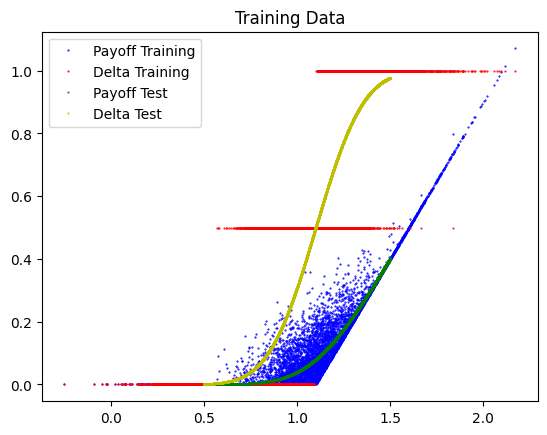

In [4]:
class Bachelier:
    
    def __init__(self, 
                 n,
                 T1=1.0, 
                 T2=2.0, 
                 K=1.10,
                 volMult=1.5):
        self.n = n
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                
    # training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
    def trainingSet(self, m, anti=True, seed=None, bktVol=0.2):
    
        tf.random.set_seed(seed)

        # spots all currently 1, without loss of generality
        self.S0 = tf.ones(self.n)
        # random correl
        self.corr = genCorrel(self.n)

        # random weights
        self.a = tf.random.uniform(minval=1., maxval=10., shape=(self.n,))

        # self.a /= np.sum(self.a)
        self.a /= tf.reduce_sum(self.a)

        # random vols
        # vols = np.random.uniform(low=5., high = 50., size = self.n)
        vols = tf.random.uniform(minval=5., maxval=50., shape=(self.n,))

        # normalize vols for a given volatility of basket, 
        # helps with charts without loss of generality
        # avols = (self.a * vols).reshape((-1,1))
        avols = tf.reshape(self.a * vols, (-1,1))

        v = tf.sqrt(tf.transpose(avols) @ self.corr @ avols)
        v = tf.squeeze(v, axis=1)

        self.vols = vols * bktVol / v
        self.bktVol = bktVol

        # Choleski etc. for simulation
        diagv = tf.linalg.diag(self.vols)
        # self.cov = np.linalg.multi_dot([diagv, self.corr, diagv])
        self.cov = diagv @ self.corr @ diagv
        # self.chol = np.linalg.cholesky(self.cov) * np.sqrt(self.T2 - self.T1)
        self.chol = tf.linalg.cholesky(self.cov) * tf.math.sqrt(self.T2 - self.T1)
        # increase vols for simulation of X so we have more samples in the wings
        self.chol0 = self.chol * self.volMult * tf.sqrt(self.T1 / (self.T2 - self.T1))
        # simulations
        normals = tf.random.normal(shape=[2, m, self.n])
        inc0 = normals[0, :, :] @ tf.transpose(self.chol0)
        inc1 = normals[1, :, :] @ tf.transpose(self.chol)
    
        S1 = self.S0 + inc0
        
        S2 = S1 + inc1
        # bkt2 = np.dot(S2, self.a)
        bkt2 = tf.tensordot(S2, self.a, axes=1)

        pay = tf.math.maximum(0, bkt2 - self.K)

        # two antithetic paths
        if anti:
            
            S2a = S1 - inc1
            bkt2a = tf.tensordot(S2a, self.a, axes=1)
            paya = tf.math.maximum(0, bkt2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 = tf.reshape(tf.where(bkt2 > self.K, 1.0, 0.0), (-1, 1)) * tf.reshape(self.a, (1, -1))
            Z2 =  tf.reshape(tf.where(bkt2a > self.K, 1.0, 0.0), (-1,1)) * tf.reshape(self.a, (1, -1))
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z = tf.reshape(tf.where(bkt2 > self.K, 1.0, 0.0), (-1, 1)) * tf.reshape(self.a, (1, -1))
            
        return X, tf.reshape(Y, (-1,1)), Z
    
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas
    def testSet(self, lower=0.5, upper=1.50, num=4096, seed=None):
        
        tf.random.set_seed(seed)
        # adjust lower and upper for dimension
        adj = 1 + 0.5 * tf.math.sqrt((self.n-1)*(upper-lower)/12)
        adj_lower = 1.0 - (1.0-lower) * adj
        adj_upper = 1.0 + (upper - 1.0) * adj
        # draw spots
        spots = tf.random.uniform(minval=adj_lower, maxval=adj_upper, shape=(num, self.n))
        # compute baskets, prices, deltas and vegas
        baskets = tf.reshape(tf.tensordot(spots, self.a, axes=1), (-1, 1))
        prices = tf.reshape(bachPrice(baskets, self.K, self.bktVol, self.T2 - self.T1),(-1, 1))
        deltas = bachDelta(baskets, self.K, self.bktVol, self.T2 - self.T1) @ tf.reshape(self.a, (1, -1))
        vegas = bachVega(baskets, self.K, self.bktVol, self.T2 - self.T1) 
        return spots, baskets, prices, deltas, vegas    

bach = Bachelier(1)
X, Y, Z = bach.trainingSet(10000)
spots, baskets, prices, deltas, vegas = bach.testSet(num=10000)


# plot training set:

def plot_training_data(x_train, y_train, dydx_train, x_test, y_test, dydx_test):
    plt.title("Training Data")
    plt.plot(x_train, y_train, 'b.', label='Payoff Training', markersize=1)
    plt.plot(x_train, dydx_train, 'r.', label='Delta Training', markersize=1)
    plt.plot(x_test, y_test, 'g.', label='Payoff Test', markersize=1)
    plt.plot(x_test, dydx_test, 'y.', label='Delta Test', markersize=1)
    plt.legend()
    plt.show()


plot_training_data(X[:,0], Y[:,0], Z[:,0], spots[:, 0], prices[:,0], deltas[:,0])


(10000, 2)
(10000, 1)
(10000, 2)
(10000,)


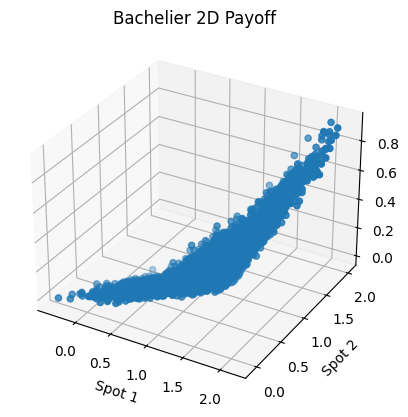

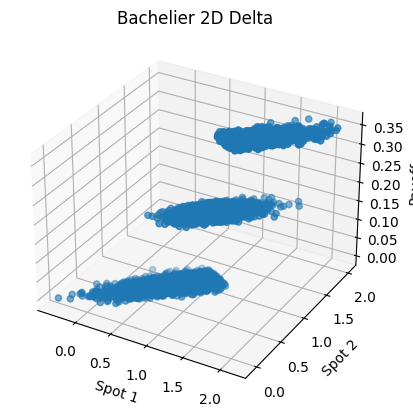

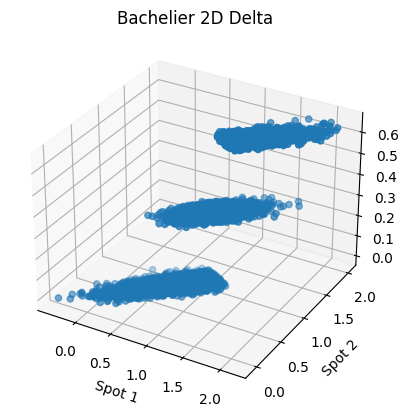

In [5]:
# 3d plot of Bachelier with 2 underlyings dimensions:

def plot_bachelier_3d(x, y, z, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, marker='o')
    ax.set_xlabel('Spot 1')
    ax.set_ylabel('Spot 2')
    ax.set_zlabel('Payoff')
    ax.set_title(title)
    plt.show()

bach = Bachelier(2)
x, y, z = bach.trainingSet(10000)
print(x.shape)
print(y.shape)
print(z.shape)

print(x[:, 0].shape)

# plt.plot(x[:, 0], y, 'b.', label='Payoff', markersize=1)
# plt.show()
# plt.plot(x[:, 1], z[:, 1], 'r.', label='Delta 1', markersize=1)
# plt.show()
plot_bachelier_3d(x[:, 0], x[:, 1], y, "Bachelier 2D Payoff")
plot_bachelier_3d(x[:, 0], x[:, 1], z[:, 0], "Bachelier 2D Delta")
plot_bachelier_3d(x[:, 0], x[:, 1], z[:, 1], "Bachelier 2D Delta")

In [44]:
bach = Bachelier(1)
x_train, y_train, dydx_train = bach.trainingSet(8192)
spots, baskets, prices, deltas, vegas = bach.testSet(num=4096)

x_test = spots
y_test = prices
dydx_test = deltas

(4096, 1)
(8192, 1)


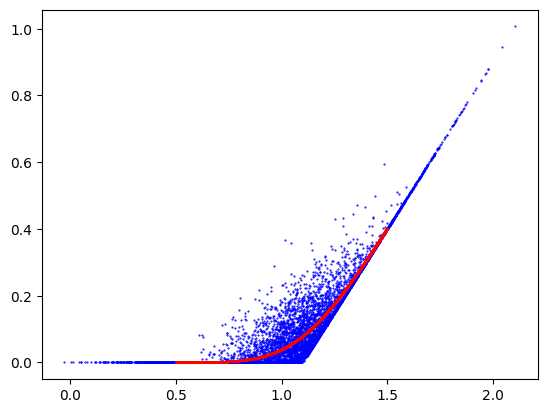

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

In [45]:
print(dydx_test.shape)
print(y_train.shape)

plt.plot(x_train[:, 0], y_train, 'b.', label='Payoff Train', markersize=1)
plt.plot(baskets, y_test, 'r.', label='Payoff Test', markersize=1)
plt.show()

plt.plot(x_train[:, 0], dydx_train[:, 1], 'b.', label='Delta Train', markersize=1)
plt.plot(baskets[:, 0], dydx_test[:, 1], 'r.', label='Payoff Test', markersize=1)

plt.show()


In [46]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE) 

In [58]:
x_normalizer = tf.keras.layers.Normalization()
x_normalizer.adapt(x_train)

y_denormalizer = tf.keras.layers.Normalization(invert=True)
y_denormalizer.adapt(y_train)

In [93]:
input_shape = x_train.shape[1:]
# create a new model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    x_normalizer,
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(20, activation=ACTIVATION),
    tf.keras.layers.Dense(1),
    y_denormalizer
], name="SurrogateModelWithoutDifferentials")


optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss_metric = tf.keras.metrics.Mean(name='train_loss')
loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer, loss=loss_fn)

def loss(model, x, y):
    y_pred = model(x)
    return loss_fn(y_true=y, y_pred=y_pred)


@tf.function
def train_step(model, x, y, dydx):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    loss_metric.update_state(loss_value)

for epoch in range(NUM_EPOCHS):
    loss_metric.reset_states()

    for xs, ys, dydxs in train_dataset:
        train_step(model, xs, ys, dydxs)
    
    mean_loss = loss_metric.result()

    print('Finished epoch {:3d}'.format(epoch), ' |  Loss: {:.5f}'.format(mean_loss))


Finished epoch   0  |  Loss: 0.01613
Finished epoch   1  |  Loss: 0.01389
Finished epoch   2  |  Loss: 0.01200
Finished epoch   3  |  Loss: 0.01034
Finished epoch   4  |  Loss: 0.00891
Finished epoch   5  |  Loss: 0.00769
Finished epoch   6  |  Loss: 0.00670
Finished epoch   7  |  Loss: 0.00592
Finished epoch   8  |  Loss: 0.00533
Finished epoch   9  |  Loss: 0.00489
Finished epoch  10  |  Loss: 0.00455
Finished epoch  11  |  Loss: 0.00427
Finished epoch  12  |  Loss: 0.00404
Finished epoch  13  |  Loss: 0.00382
Finished epoch  14  |  Loss: 0.00363
Finished epoch  15  |  Loss: 0.00344
Finished epoch  16  |  Loss: 0.00326
Finished epoch  17  |  Loss: 0.00308
Finished epoch  18  |  Loss: 0.00292
Finished epoch  19  |  Loss: 0.00277
Finished epoch  20  |  Loss: 0.00263
Finished epoch  21  |  Loss: 0.00250
Finished epoch  22  |  Loss: 0.00238
Finished epoch  23  |  Loss: 0.00228
Finished epoch  24  |  Loss: 0.00219
Finished epoch  25  |  Loss: 0.00211
Finished epoch  26  |  Loss: 0.00204
F

128/128 [==============================] - 0s 1ms/step
RMSE 0.002502378774806857


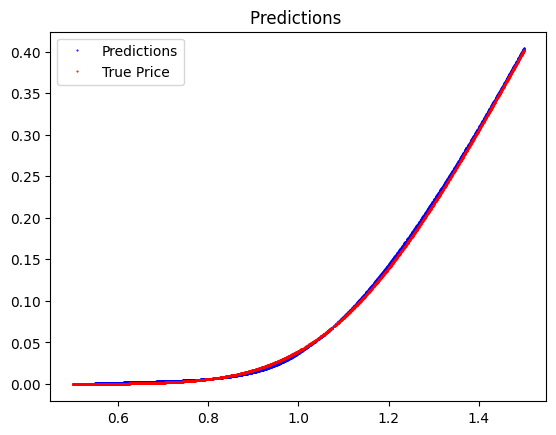

In [94]:
pred_y = model.predict(x_test)

test_rmse = tf.sqrt(model.loss(y_test, pred_y))
print(f"RMSE {test_rmse}")

plt.title("Predictions ")
plt.plot(baskets[:, 0], pred_y, 'b.', markersize=1)
plt.plot(baskets[:, 0], y_test, 'r.', markersize=1)
plt.legend(['Predictions', 'True Price'], loc='upper left')
plt.show()